# HAT Substrate Comparison - Neutral vs Emotional

This notebook loads and explores the data collected by `substrate_collector.py`
during two LLM inference runs (one per prompt condition) on a CloudLab bare-metal node.

**Data sources per run:**

| File | Resolution | Content |
|------|------------|---------|
| `perf_stat.txt` | 1 ms buckets | 16 system-wide perf events (IRQs, softirqs, TLB, power) |
| `proc_sample.csv` | 200 ms | Per-process CPU time + RSS for the llama.cpp container PID |
| `proc_system_sample.csv` | 200 ms | /proc/interrupts, /proc/softirqs, PSI, net, disk, freq |
| `responses.jsonl` | per request | LLM request timing + llama.cpp internal metrics |
| `collector_meta.json` | once | Collector config, t0/t1 timestamps |

**Timing model:** Each run records a fixed **44 s** window
(2 s baseline + 40 s prompt budget + 2 s tail) so the time axes are directly comparable.

In [1]:
import re, json
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = (12, 4)

## 1 - Configuration

Point `BASE_DIR` at the folder that contains your run directories.
Each run directory name looks like `2026-02-09T22-18-50_emotional`.

In [2]:
BASE_DIR = Path.home() / 'Desktop' / 'mccviahat' / 'runs'

NEUTRAL_RUN   = '2026-02-11T00-12-58_neutral'
EMOTIONAL_RUN = '2026-02-10T23-48-36_emotional'

n_dir = BASE_DIR / NEUTRAL_RUN
e_dir = BASE_DIR / EMOTIONAL_RUN

for d in [n_dir, e_dir]:
    assert d.exists(), f'Missing: {d}'
print('Both run directories found')

Both run directories found


## 2 - Parsers

### perf stat parser

Each line in `perf_stat.txt` follows this format (the `#` comment is always present):
```
<timestamp>  <value>            <event_name>             # <rate> /sec
<timestamp>  <value> <unit>     <event_name>             # <rate> <desc>
```

The event name is always the **last token before the `#`**.  This makes parsing robust
regardless of whether a unit (`msec`, `Joules`, `C`) is present.

In [3]:
def parse_perf_stat(path: Path) -> pd.DataFrame:
    """Parse perf stat -I output into tidy (t_s, event, value) rows.
    
    Strategy: split each line on '#', take the left side,
    the event name is the LAST token before '#'.
    """
    rows = []
    for line in path.read_text(encoding='utf-8', errors='replace').splitlines():
        line = line.strip()
        if not line or line.startswith('#'):
            continue
        parts = line.split('#', 1)
        left = parts[0].strip()
        tokens = left.split()
        if len(tokens) < 3:
            continue
        
        t_s_str = tokens[0]
        event   = tokens[-1]       # last token before '#'
        raw_val = tokens[1]        # second token is the count/value
        
        try:
            t_s = float(t_s_str)
        except ValueError:
            continue
        
        raw_val = raw_val.replace(',', '')
        if raw_val.startswith('<'):
            val = np.nan
        else:
            try:
                val = float(raw_val)
            except ValueError:
                val = np.nan
        
        rows.append((t_s, event, val))
    
    return pd.DataFrame(rows, columns=['t_s', 'event', 'value'])


def perf_to_wide(tidy: pd.DataFrame) -> pd.DataFrame:
    """Pivot tidy perf -> wide: one row per timestamp, one column per event."""
    w = tidy.pivot_table(index='t_s', columns='event', values='value', aggfunc='first')
    return w.sort_index().reset_index()

### Response and /proc loaders

In [4]:
def load_json(path: Path) -> dict:
    return json.loads(path.read_text(encoding='utf-8'))


def load_responses(run_dir: Path) -> pd.DataFrame:
    """Load responses.jsonl and extract llama.cpp timings."""
    rows = []
    for line in (run_dir / 'responses.jsonl').read_text(encoding='utf-8').splitlines():
        if not line.strip():
            continue
        r = json.loads(line)
        try:
            resp = json.loads(r['response_raw'])
            timings = resp.get('timings', {})
            r['prompt_ms']         = timings.get('prompt_ms')
            r['predicted_ms']      = timings.get('predicted_ms')
            r['tokens_evaluated']  = resp.get('tokens_evaluated')
            r['tokens_predicted']  = resp.get('tokens_predicted')
        except Exception:
            pass
        rows.append(r)
    df = pd.DataFrame(rows)
    keep = [c for c in ['id', 'title', 'ok', 't_request_start_ns', 't_request_end_ns',
                         'prompt_ms', 'predicted_ms', 'tokens_evaluated', 'tokens_predicted']
            if c in df.columns]
    df = df[keep].sort_values('t_request_start_ns').reset_index(drop=True)
    df['duration_s'] = (df['t_request_end_ns'] - df['t_request_start_ns']) / 1e9
    return df


def load_proc_system(run_dir: Path) -> pd.DataFrame:
    """Load proc_system_sample.csv and add relative time."""
    df = pd.read_csv(run_dir / 'proc_system_sample.csv')
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df


def load_proc_sample(run_dir: Path) -> pd.DataFrame:
    """Load proc_sample.csv (per-process stats) and add relative time."""
    df = pd.read_csv(run_dir / 'proc_sample.csv')
    df['t_s'] = (df['timestamp_ns'] - df['timestamp_ns'].iloc[0]) / 1e9
    return df

## 3 - Load all data

In [5]:
n_cmeta = load_json(n_dir / 'collector_meta.json')
e_cmeta = load_json(e_dir / 'collector_meta.json')

n_resp = load_responses(n_dir)
e_resp = load_responses(e_dir)

n_perf_tidy = parse_perf_stat(n_dir / 'perf_stat.txt')
e_perf_tidy = parse_perf_stat(e_dir / 'perf_stat.txt')
n_perf = perf_to_wide(n_perf_tidy)
e_perf = perf_to_wide(e_perf_tidy)

n_sys = load_proc_system(n_dir)
e_sys = load_proc_system(e_dir)

n_proc = load_proc_sample(n_dir)
e_proc = load_proc_sample(e_dir)

# Sanity report
perf_events = sorted(n_perf_tidy['event'].unique())
print(f'Perf events found ({len(perf_events)}): {perf_events}')
print(f'Perf rows   - neutral: {len(n_perf):,}  emotional: {len(e_perf):,}')
print(f'Proc system - neutral: {len(n_sys)}  emotional: {len(e_sys)}')
print(f'Responses   - neutral: {len(n_resp)}/5  emotional: {len(e_resp)}/5')
if len(e_resp) < 5:
    print(f'  -> Emotional has {len(e_resp)}/5 (prompt budget ran out - expected for long prompts)')

Perf events found (16): ['context-switches', 'core_power.throttle', 'cpu-clock', 'cpu-migrations', 'irq:irq_handler_entry', 'irq:irq_handler_exit', 'irq:softirq_entry', 'irq:softirq_exit', 'irq:softirq_raise', 'irq:tasklet_entry', 'irq:tasklet_exit', 'msr/cpu_thermal_margin/', 'page-faults', 'power/energy-pkg/', 'power/energy-ram/', 'tlb:tlb_flush']
Perf rows   - neutral: 8,107  emotional: 8,025
Proc system - neutral: 289  emotional: 287
Responses   - neutral: 5/5  emotional: 5/5


## 4 - Request timing comparison

Emotional prompts are **longer** (more tokens to evaluate) so they take more time.
With `n_predict=40`, the generation (predicted) time is similar, but prompt processing
dominates for emotional prompts (~6 s vs ~0.15 s).

In [6]:
show_cols = ['id', 'title', 'duration_s', 'tokens_evaluated', 'tokens_predicted', 'prompt_ms', 'predicted_ms']
print('=== Neutral ===')
display(n_resp[show_cols])
print(f'\n=== Emotional ({len(e_resp)}/5 completed) ===')
display(e_resp[show_cols])

=== Neutral ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,Tightening a Loose Door Hinge,11.857254,419,40,6337.998,5499.582
1,2,Replacing a Shower Curtain Rod,5.262535,355,2,5105.789,143.906
2,3,Assembling a Simple Wall Shelf,4.884136,339,1,4868.222,0.001
3,4,Fixing a Wobbly Table Leg,10.404741,334,40,4795.483,5591.265
4,5,Installing a Basic Smoke Detector,10.011571,293,40,4222.608,5417.407



=== Emotional (5/5 completed) ===


,id,title,duration_s,tokens_evaluated,tokens_predicted,prompt_ms,predicted_ms
0,1,Military Convoy Explosion,11.789916,419.0,40.0,6324.041,5441.205
1,2,Coastal Storm Flooding,11.020653,386.0,40.0,5631.949,5370.796
2,3,Apartment Intruder,11.707670,409.0,40.0,5970.156,5722.988
3,4,Highway Collision,6.307149,412.0,3.0,6009.578,280.422
4,5,Desert Ambush,12.012555,NaN,NaN,NaN,NaN


## 5 - Perf event summary

Mean event counts per 1 ms bucket, comparing the two conditions.

In [7]:
common_events = sorted(set(n_perf.columns) & set(e_perf.columns) - {'t_s'})
print(f'Events in both runs ({len(common_events)}):\n')
print(f'{"Event":35s}  {"Neutral mean":>14s}  {"Emotional mean":>14s}')
print('-' * 68)
for e in common_events:
    print(f'{e:35s}  {n_perf[e].mean():14.2f}  {e_perf[e].mean():14.2f}')

Events in both runs (16):

Event                                  Neutral mean  Emotional mean
--------------------------------------------------------------------
context-switches                             896.61         1066.30
core_power.throttle                      2688176.12      3421894.51
cpu-clock                                    505.32          510.44
cpu-migrations                               169.32          195.31
irq:irq_handler_entry                          1.04            1.04
irq:irq_handler_exit                           1.04            1.04
irq:softirq_entry                             39.94           44.81
irq:softirq_exit                              39.94           44.81
irq:softirq_raise                             40.04           44.95
irq:tasklet_entry                              0.00            0.00
irq:tasklet_exit                               0.00            0.00
msr/cpu_thermal_margin/                     1518.15         2076.24
page-faults         

## 6 - Time-series plots

Smoothed (500 ms rolling mean) time-series of key perf events.
Shaded bands mark request windows; dotted line marks the end of the 2 s baseline.

In [8]:
def request_windows(resp, t0_ns):
    return [(float(r['t_request_start_ns'] - t0_ns) / 1e9,
             float(r['t_request_end_ns']   - t0_ns) / 1e9)
            for _, r in resp.iterrows()]

n_wins = request_windows(n_resp, n_cmeta['t0_ns'])
e_wins = request_windows(e_resp, e_cmeta['t0_ns'])


def plot_event(evt, smooth_ms=500):
    if evt not in n_perf.columns or evt not in e_perf.columns:
        print(f'  {evt} not in both runs - skipping.')
        return
    fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
    for ax, label, df, wins, color in [
        (axes[0], 'Neutral',   n_perf, n_wins, 'steelblue'),
        (axes[1], 'Emotional', e_perf, e_wins, 'firebrick'),
    ]:
        smoothed = df[evt].rolling(smooth_ms, min_periods=1).mean()
        ax.plot(df['t_s'], smoothed, color=color, lw=0.8, alpha=0.9)
        for s, e in wins:
            ax.axvspan(s, e, alpha=0.10, color=color)
        ax.axvline(2.0, ls=':', color='gray', lw=0.5)
        ax.set_title(f'{label} - {evt}')
        ax.set_xlabel('time (s)')
    axes[0].set_ylabel(f'rolling {smooth_ms}ms mean')
    plt.tight_layout()
    plt.show()

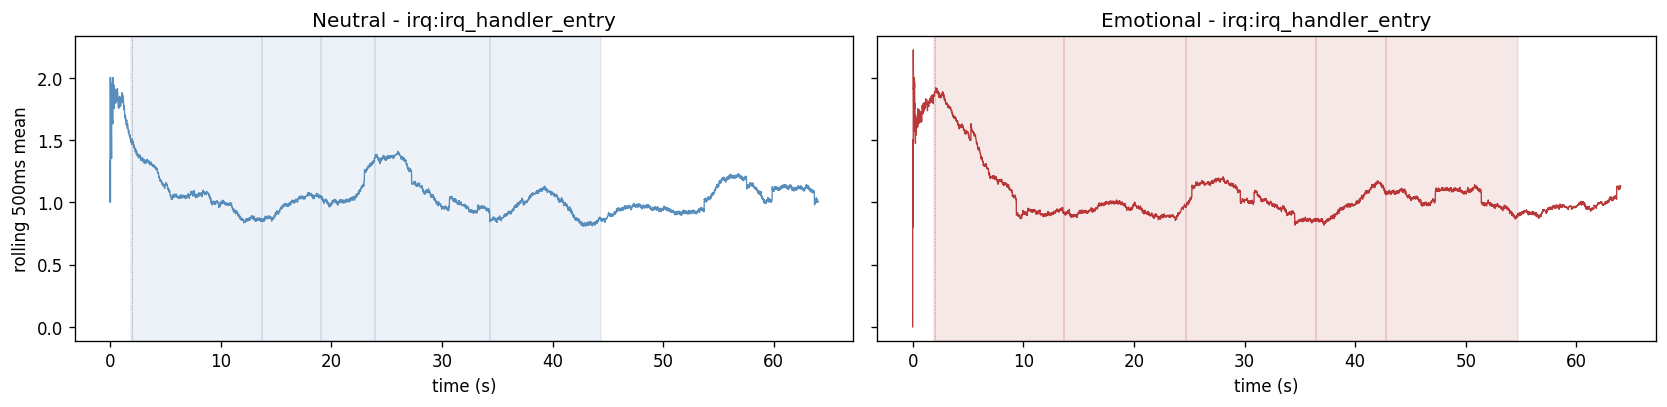

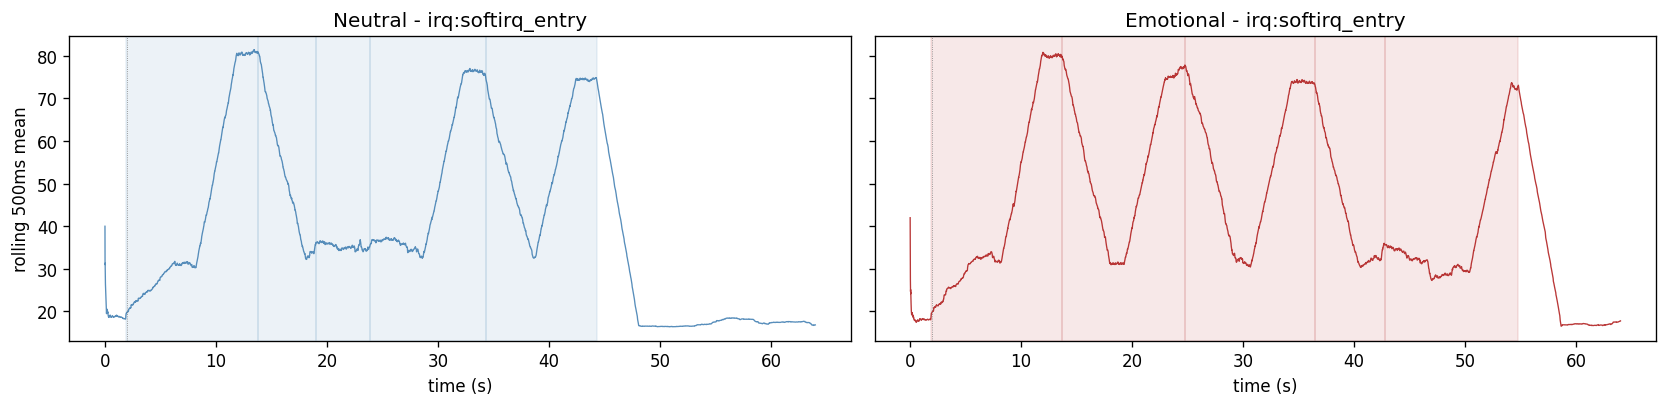

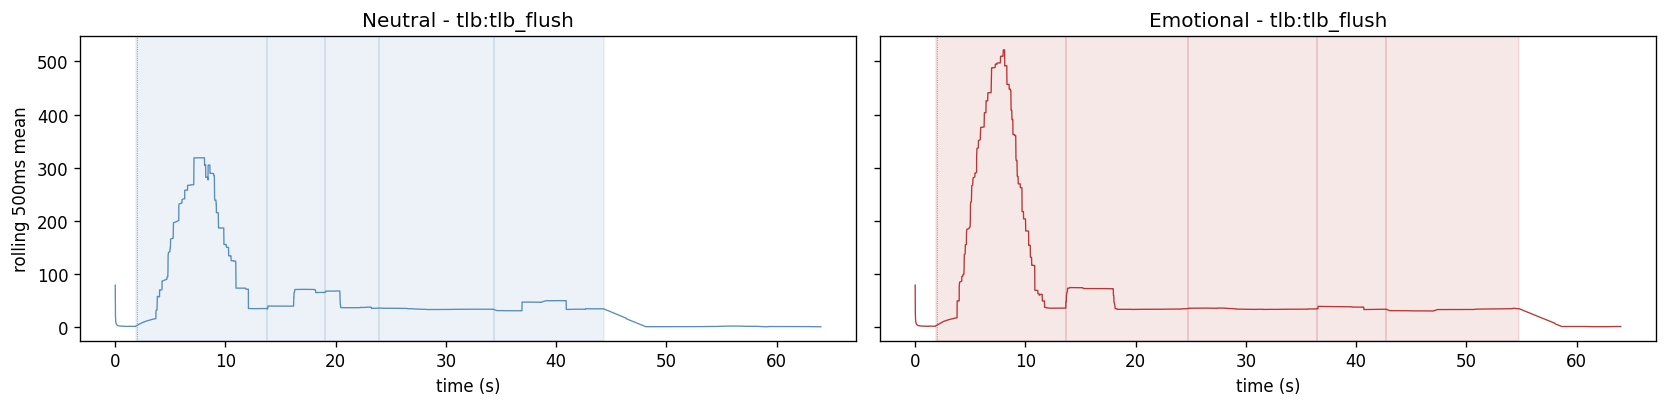

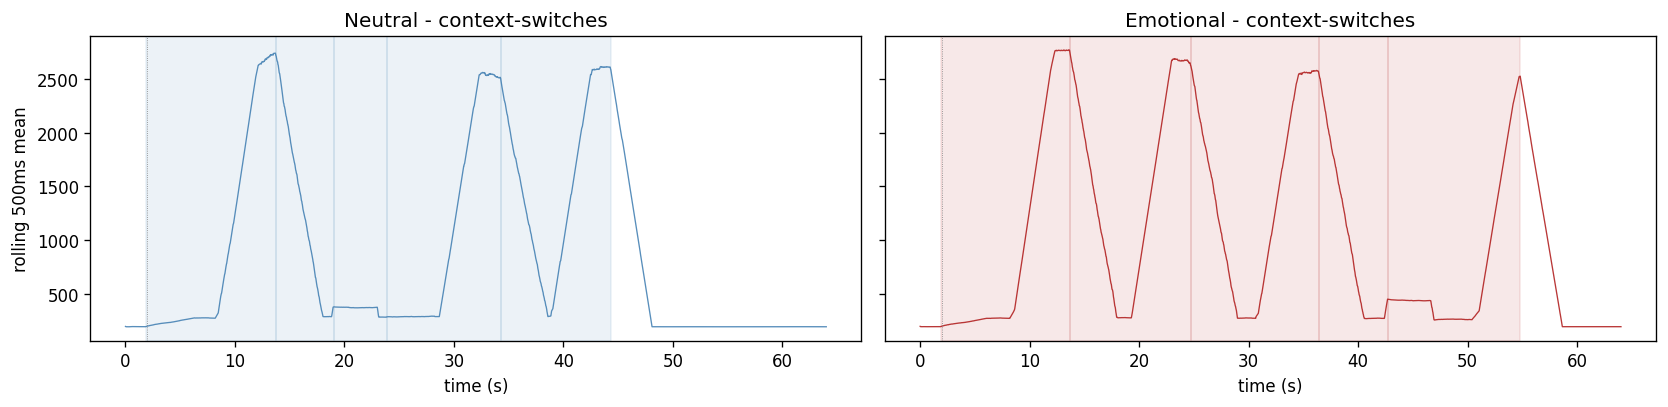

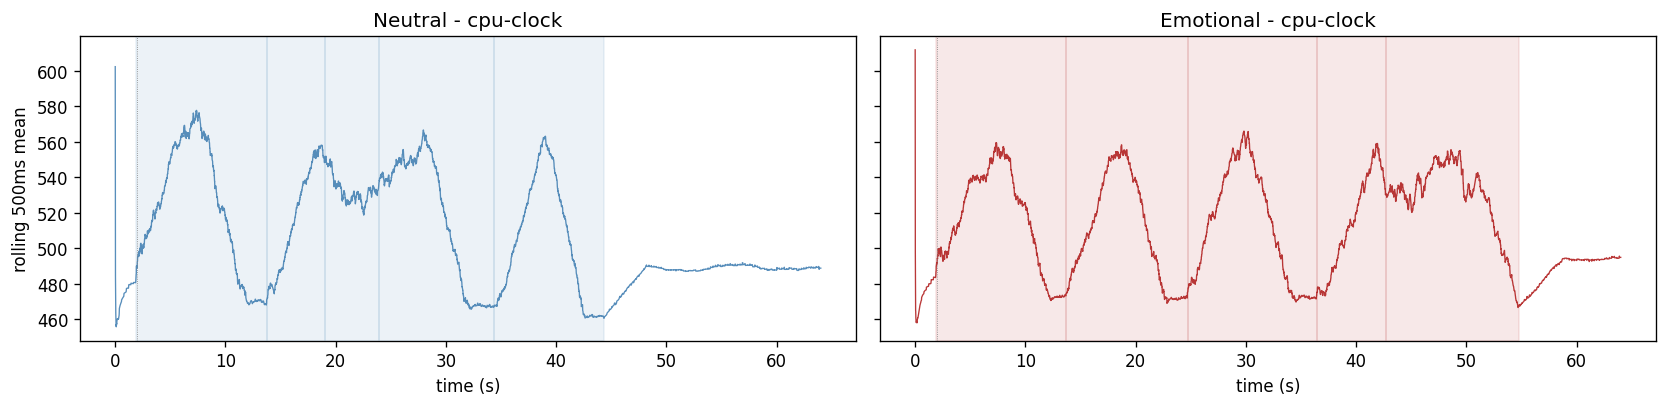

In [9]:
for evt in ['irq:irq_handler_entry', 'irq:softirq_entry', 'tlb:tlb_flush',
            'context-switches', 'cpu-clock']:
    plot_event(evt)

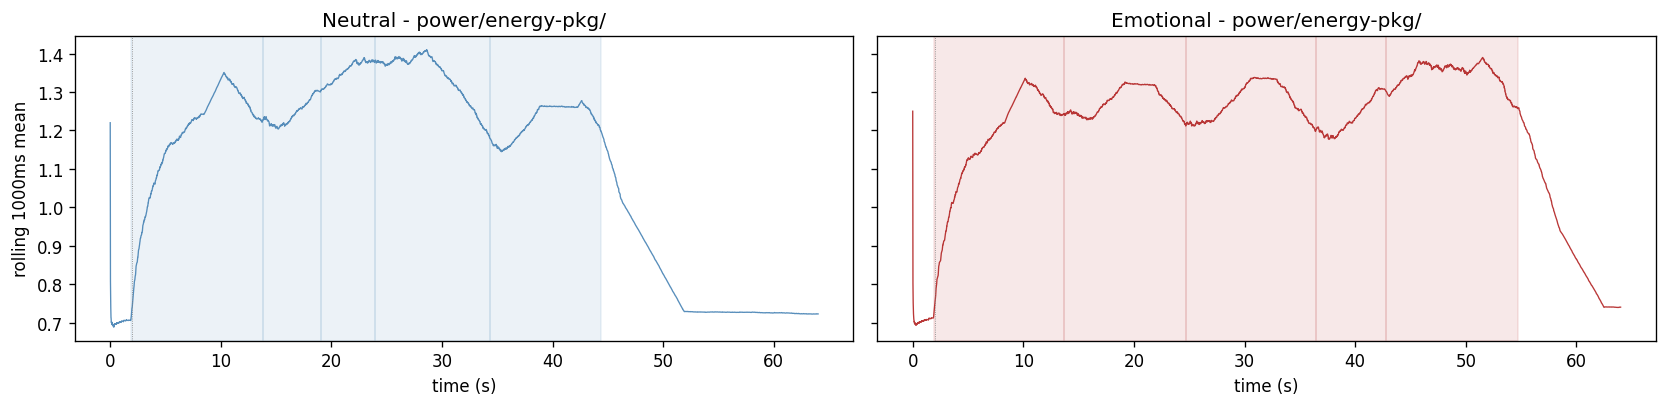

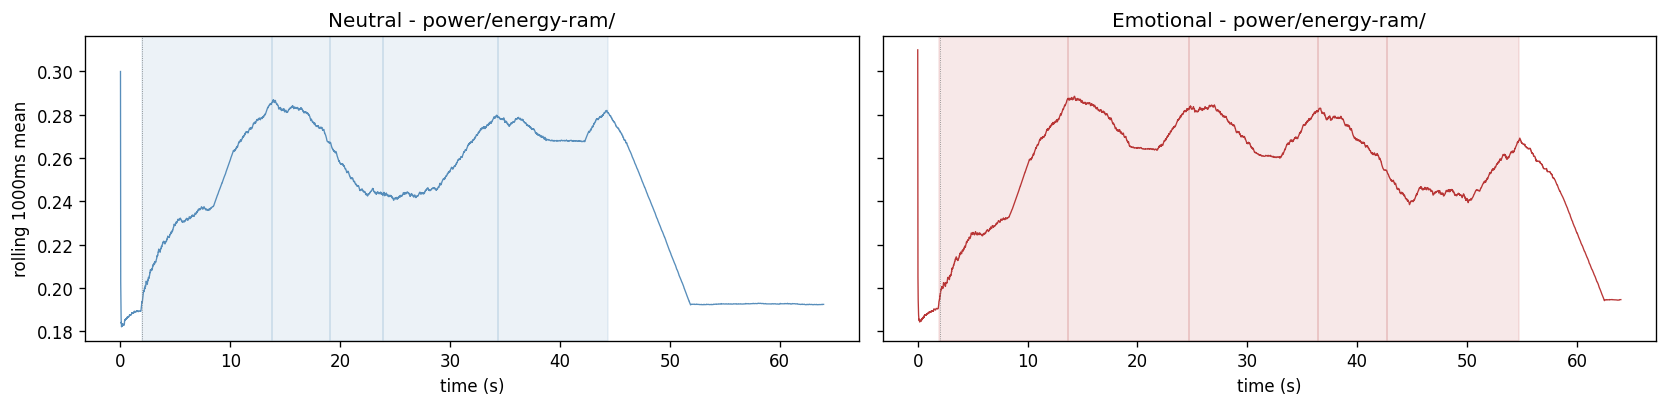

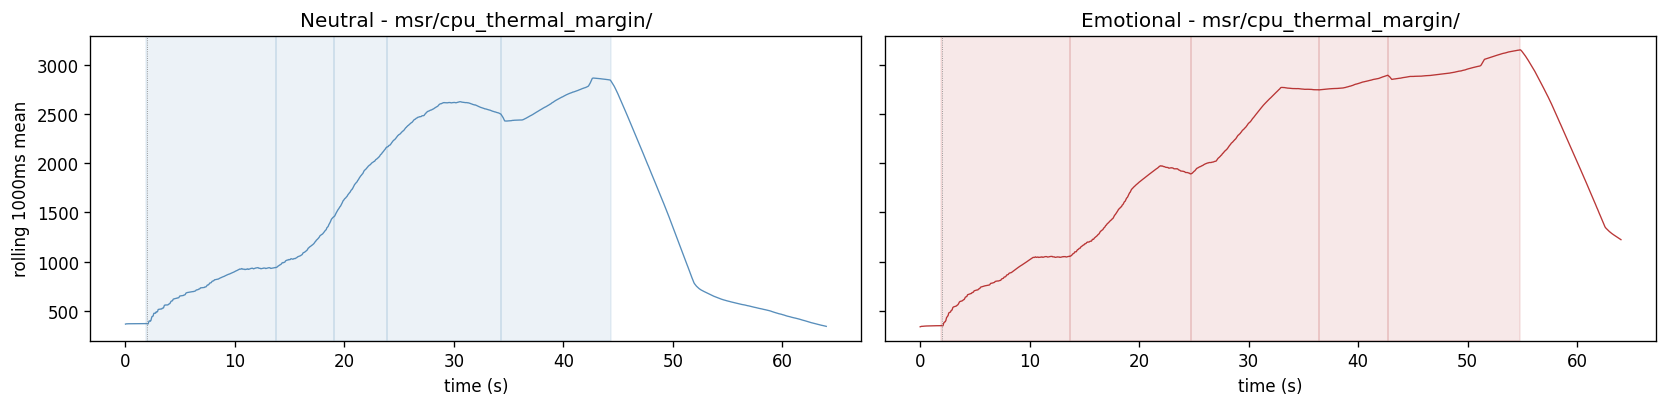

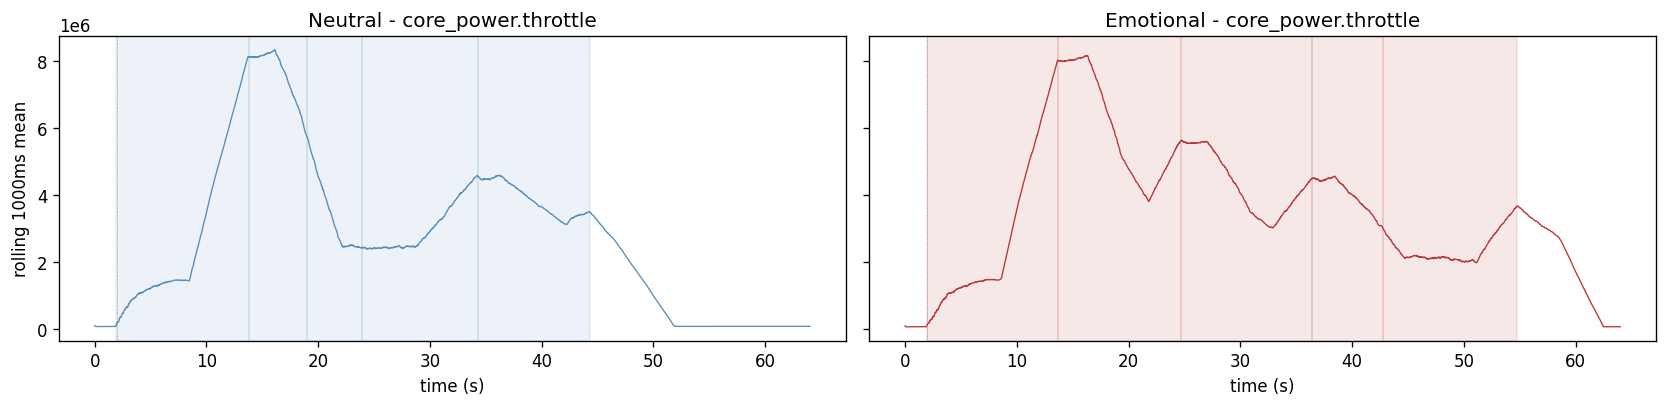

In [10]:
for evt in ['power/energy-pkg/', 'power/energy-ram/', 'msr/cpu_thermal_margin/', 'core_power.throttle']:
    plot_event(evt, smooth_ms=1000)

## 7 - Per-process CPU usage (from /proc)

`proc_sample.csv` tracks the llama.cpp container's user + system CPU jiffies at 200 ms.
We diff consecutive samples to approximate CPU utilization per interval.

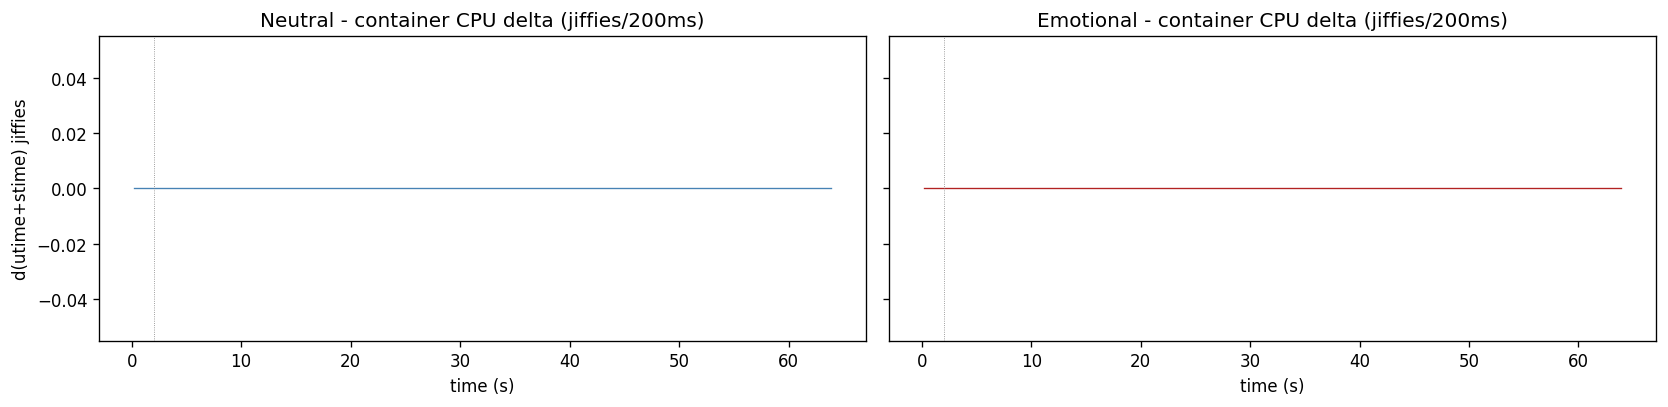

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(14, 3.5), sharey=True)
for ax, label, df, color in [
    (axes[0], 'Neutral',   n_proc, 'steelblue'),
    (axes[1], 'Emotional', e_proc, 'firebrick'),
]:
    cpu = (df['proc_utime_jiffies'] + df['proc_stime_jiffies']).diff()
    ax.plot(df['t_s'], cpu, color=color, lw=0.8)
    ax.axvline(2.0, ls=':', color='gray', lw=0.5)
    ax.set_title(f'{label} - container CPU delta (jiffies/200ms)')
    ax.set_xlabel('time (s)')
axes[0].set_ylabel('d(utime+stime) jiffies')
plt.tight_layout()
plt.show()

## 8 - /proc softirq rates

`proc_system_sample.csv` has cumulative `/proc/softirqs` counters.
Diffing gives approximate rates per 200 ms interval.

**Known issue (Feb 9 data):** PSI columns have duplicate names (cpu/memory/io all
share `full_avg10`, etc.). Also, the collector had an `or`-chain bug that dropped
values equal to 0.  Both are now fixed for the next run.

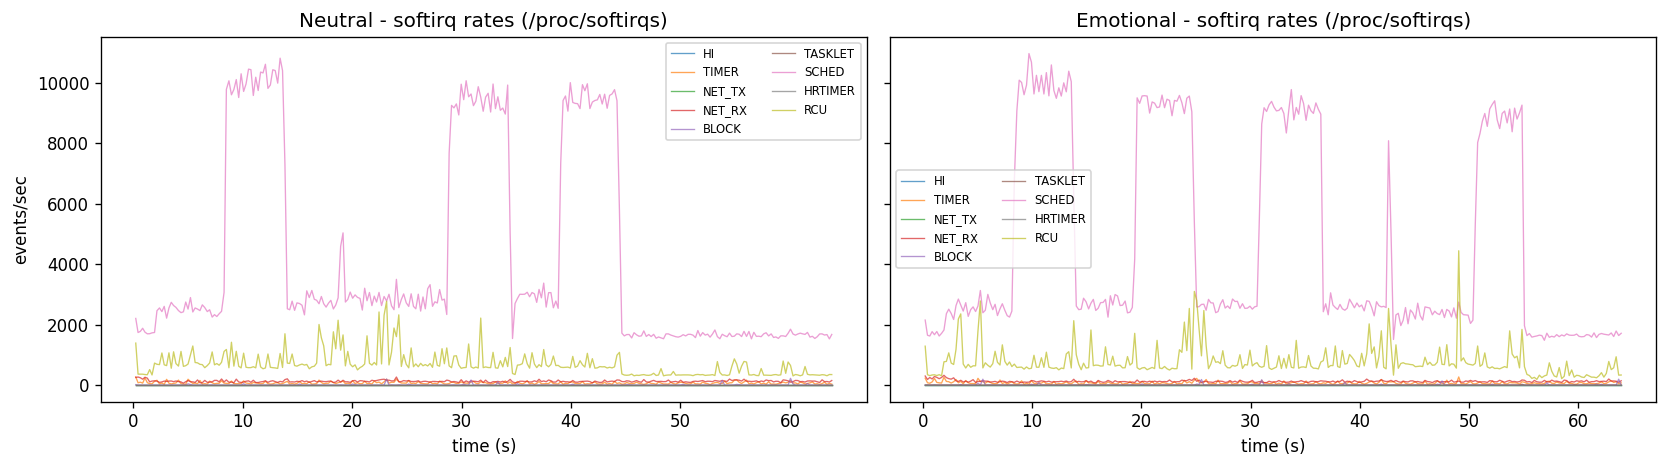

In [12]:
softirq_names = ['HI', 'TIMER', 'NET_TX', 'NET_RX', 'BLOCK', 'TASKLET', 'SCHED', 'HRTIMER', 'RCU']
available_sirqs = [s for s in softirq_names if s in n_sys.columns]

if available_sirqs:
    fig, axes = plt.subplots(1, 2, figsize=(14, 4), sharey=True)
    for ax, label, df, color in [
        (axes[0], 'Neutral',   n_sys, 'steelblue'),
        (axes[1], 'Emotional', e_sys, 'firebrick'),
    ]:
        for sirq in available_sirqs:
            rate = df[sirq].diff() / df['t_s'].diff()
            ax.plot(df['t_s'], rate, lw=0.8, alpha=0.7, label=sirq)
        ax.set_title(f'{label} - softirq rates (/proc/softirqs)')
        ax.set_xlabel('time (s)')
        ax.legend(fontsize=7, ncol=2)
    axes[0].set_ylabel('events/sec')
    plt.tight_layout()
    plt.show()
else:
    print('No softirq columns found')

## 9 - Data quality diagnostic

In [13]:
print('=' * 60)
print('DATA QUALITY SUMMARY')
print('=' * 60)

# 1. Perf events
n_events = set(n_perf_tidy['event'].unique())
e_events = set(e_perf_tidy['event'].unique())
print(f'\nPerf events: {len(n_events)} neutral, {len(e_events)} emotional')
only_n = n_events - e_events
only_e = e_events - n_events
if only_n: print(f'  Only in neutral: {only_n}')
if only_e: print(f'  Only in emotional: {only_e}')

# 2. All-zero events
print('\nAll-zero perf events (recorded but never fired):')
any_zero = False
for evt in common_events:
    n_sum, e_sum = n_perf[evt].sum(), e_perf[evt].sum()
    if n_sum == 0 and e_sum == 0:
        print(f'  {evt} - zero in both')
        any_zero = True
    elif n_sum == 0 or e_sum == 0:
        print(f'  {evt} - zero in {"neutral" if n_sum == 0 else "emotional"} only')
        any_zero = True
if not any_zero:
    print('  (none)')

# 3. Responses
print(f'\nResponses: neutral={len(n_resp)}/5, emotional={len(e_resp)}/5')
if len(e_resp) < 5:
    print('  Emotional prompts are ~2x longer (~400 vs ~220 tokens).')
    print('  At ~11s per prompt, only 4 fit in the 40s budget. This is expected.')
    print('  Consider: increase budget_s to 60s, or reduce n_predict.')

# 4. Duplicate column names in proc_system_sample (PSI bug)
dup_cols = n_sys.columns[n_sys.columns.duplicated()].tolist()
if dup_cols:
    print(f'\nDuplicate columns in proc_system_sample: {set(dup_cols)}')
    print('  -> PSI columns for cpu/memory/io share names. Fixed for next run.')

# 5. proc_system NaN check
n_nans = n_sys.isna().sum()
problem_cols = n_nans[n_nans > 0]
if len(problem_cols) > 0:
    print(f'\nproc_system_sample NaN columns ({len(problem_cols)}):')
    for c, cnt in problem_cols.items():
        print(f'  {c}: {cnt}/{len(n_sys)} NaN')
else:
    print('\nproc_system_sample: no NaN values')

print('\n' + '=' * 60)

DATA QUALITY SUMMARY

Perf events: 16 neutral, 16 emotional

All-zero perf events (recorded but never fired):
  (none)

Responses: neutral=5/5, emotional=5/5

proc_system_sample: no NaN values



## Next steps

This notebook is for **exploration** only. Once you have multiple runs per condition
(replications), the statistical analysis will:

1. Aggregate per-run summaries (mean event rate during inference window)
2. Compare conditions with Mann-Whitney U / permutation tests
3. Compute effect sizes (Cohen's d, rank-biserial correlation)
4. Apply multiple-comparison correction (Holm-Bonferroni)

**Action items from this exploration:**
- Re-run with the fixed collector (PSI prefixes + or-chain fix)
- Consider increasing `budget_s` to 60 s so all 5 emotional prompts complete
- Collect >= 10 replications per condition for meaningful statistics

In [14]:
from scipy import stats as sp_stats
from collections import defaultdict

# ── helper: extract per-request windows from perf wide df ──
def extract_request_series(perf_df, wins, events=None):
    """Return list of dicts {event: np.array} for each request window."""
    if events is None:
        events = [c for c in perf_df.columns if c != 't_s']
    segments = []
    for start, end in wins:
        mask = (perf_df['t_s'] >= start) & (perf_df['t_s'] <= end)
        seg = {}
        for evt in events:
            seg[evt] = perf_df.loc[mask, evt].values.astype(float)
        seg['_t_s'] = perf_df.loc[mask, 't_s'].values
        seg['_duration_s'] = end - start
        segments.append(seg)
    return segments

n_segs = extract_request_series(n_perf, n_wins, common_events)
e_segs = extract_request_series(e_perf, e_wins, common_events)
print(f'Neutral segments: {len(n_segs)}, Emotional segments: {len(e_segs)}')
print(f'Samples per segment (first): {len(n_segs[0]["_t_s"])}, {len(e_segs[0]["_t_s"])}')

Neutral segments: 5, Emotional segments: 5
Samples per segment (first): 1468, 1474


## 6.1 Frequency Features
- **Event rate** (events / second): total count in window ÷ window duration
- **Relative share**: each event's rate as a fraction of the total across all events

These capture the *intensity* of each interrupt class during LLM inference.

In [15]:
# ── 6.1  Frequency Features ──
def compute_frequency_features(segments, events):
    """Return DataFrame: rows = segments, cols = event_rate, event_share."""
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        rates = {}
        for evt in events:
            rates[evt] = seg[evt].sum() / dur if dur > 0 else 0.0
        total_rate = sum(rates.values())
        row = {}
        for evt in events:
            row[f'{evt}__rate'] = rates[evt]
            row[f'{evt}__share'] = rates[evt] / total_rate if total_rate > 0 else 0.0
        rows.append(row)
    return pd.DataFrame(rows)

n_freq = compute_frequency_features(n_segs, common_events)
e_freq = compute_frequency_features(e_segs, common_events)

# ── Summary table ──
rate_cols = [c for c in n_freq.columns if c.endswith('__rate')]
summary = []
for col in rate_cols:
    evt = col.replace('__rate', '')
    summary.append({
        'event': evt,
        'neutral_rate_mean': n_freq[col].mean(),
        'neutral_rate_std': n_freq[col].std(),
        'emotional_rate_mean': e_freq[col].mean(),
        'emotional_rate_std': e_freq[col].std(),
        'ratio_E/N': e_freq[col].mean() / n_freq[col].mean() if n_freq[col].mean() > 0 else np.nan,
    })
freq_summary = pd.DataFrame(summary).sort_values('neutral_rate_mean', ascending=False)
print('Event rates (events/s) per request window:\n')
print(freq_summary.to_string(index=False, float_format='{:.2f}'.format))

Event rates (events/s) per request window:

                  event  neutral_rate_mean  neutral_rate_std  emotional_rate_mean  emotional_rate_std  ratio_E/N
    core_power.throttle       454498723.15      199015581.79         495906368.11        187428671.65       1.09
msr/cpu_thermal_margin/          257951.70          97948.40            289527.29           104169.28       1.12
       context-switches          133438.56          87375.48            146711.82            60564.96       1.10
              cpu-clock           63983.66             59.86             63996.15               34.31       1.00
            page-faults           52109.84          47129.09             47829.53            47902.51       0.92
         cpu-migrations           24289.08          13469.22             26390.51             9356.61       1.09
          tlb:tlb_flush            7811.67           5766.72              8755.98             9424.91       1.12
      irq:softirq_raise            6008.86          

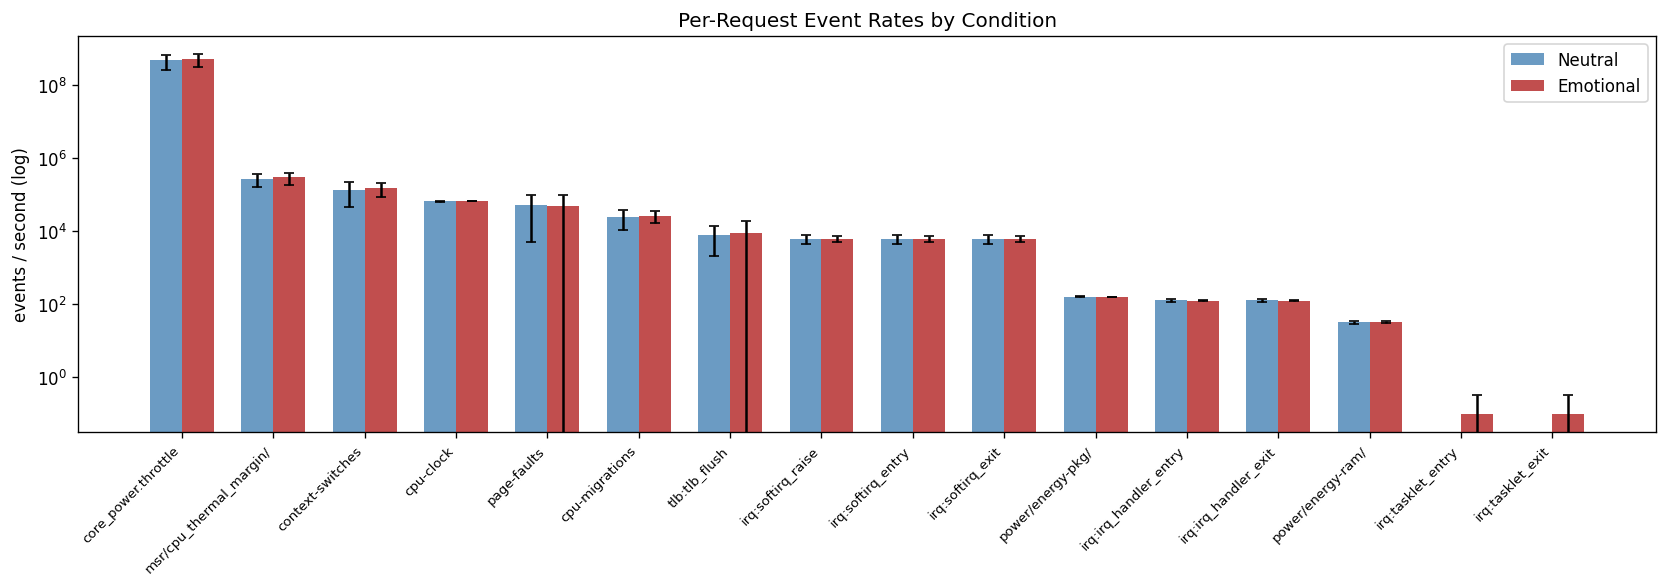

/var/folders/h6/72885xfn72j09dqwjl2d30yw0000gn/T/ipykernel_30985/1897108907.py:37: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  textprops={'fontsize': 7}, colors=plt.cm.get_cmap(cmap)(np.linspace(0.3, 0.9, len(plot_shares))))


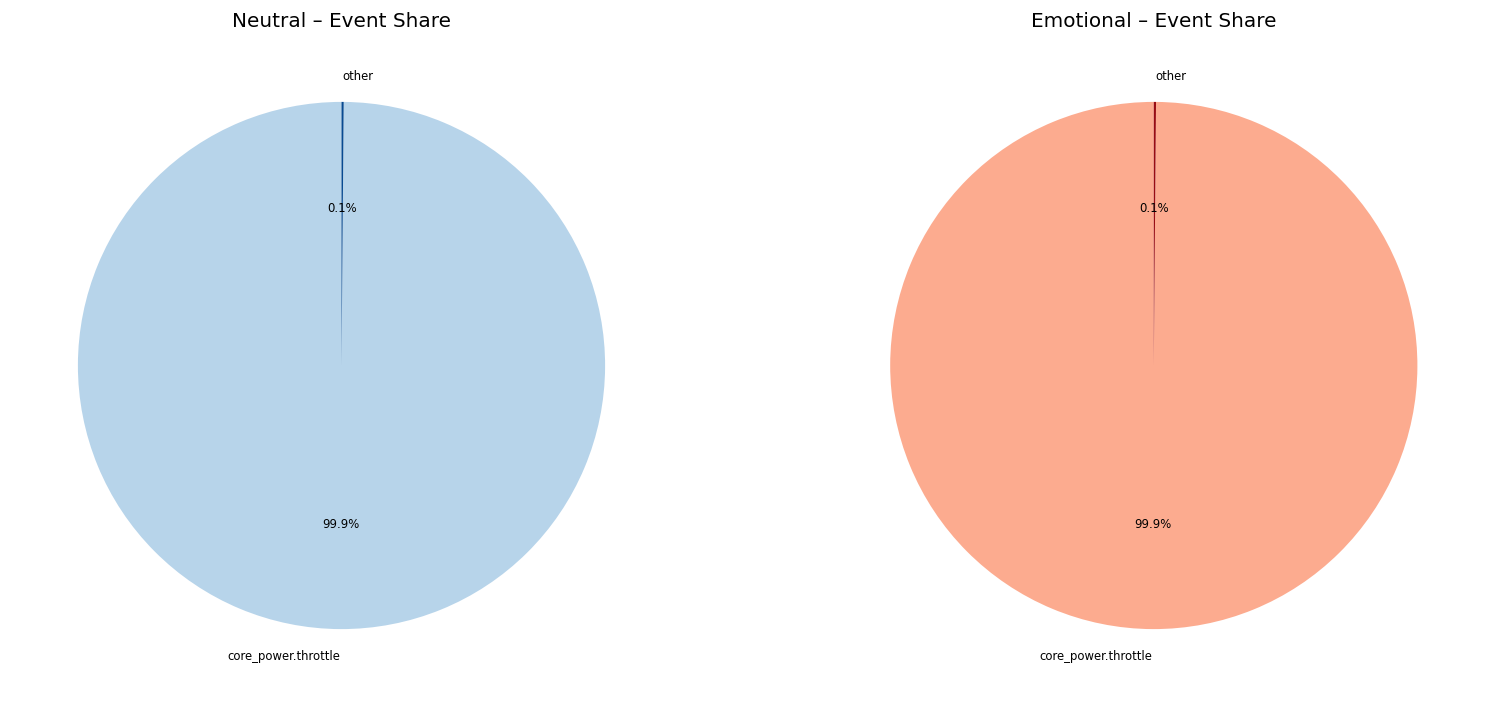

In [16]:
# ── 6.1 plot: Event rates grouped bar ──
rate_events = freq_summary['event'].values
x = np.arange(len(rate_events))
w = 0.35

fig, ax = plt.subplots(figsize=(14, 5))
ax.bar(x - w/2, freq_summary['neutral_rate_mean'],  w, yerr=freq_summary['neutral_rate_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=3)
ax.bar(x + w/2, freq_summary['emotional_rate_mean'], w, yerr=freq_summary['emotional_rate_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=3)
ax.set_yscale('log')
ax.set_xticks(x)
ax.set_xticklabels(rate_events, rotation=45, ha='right', fontsize=8)
ax.set_ylabel('events / second (log)')
ax.set_title('Per-Request Event Rates by Condition')
ax.legend()
plt.tight_layout()
plt.show()

# ── Relative share pie charts ──
share_cols = [c for c in n_freq.columns if c.endswith('__share')]
n_shares = n_freq[share_cols].mean()
e_shares = e_freq[share_cols].mean()
labels = [c.replace('__share', '') for c in share_cols]

fig, axes = plt.subplots(1, 2, figsize=(14, 6))
for ax, shares, title, cmap in [
    (axes[0], n_shares.values, 'Neutral – Event Share', 'Blues'),
    (axes[1], e_shares.values, 'Emotional – Event Share', 'Reds'),
]:
    # Collapse tiny slices into "other"
    thresh = 0.02
    big = shares >= thresh
    plot_shares = list(shares[big]) + [shares[~big].sum()]
    plot_labels = [labels[i] for i in range(len(labels)) if big[i]] + ['other']
    ax.pie(plot_shares, labels=plot_labels, autopct='%1.1f%%', startangle=90,
           textprops={'fontsize': 7}, colors=plt.cm.get_cmap(cmap)(np.linspace(0.3, 0.9, len(plot_shares))))
    ax.set_title(title)
plt.tight_layout()
plt.show()

## 6.2 Temporal Structure
- **Inter-arrival time entropy** (Shannon, bits): higher → more irregular spacing
  between events. We bin the 1ms count series to identify "arrivals" (count > 0)
  and compute entropy of the inter-arrival time distribution.
- **Fano Factor** ($F = \sigma^2 / \mu$): variance-to-mean ratio of windowed counts.
  $F = 1$ → Poisson, $F > 1$ → bursty/super-Poisson, $F < 1$ → regular.
  Computed in non-overlapping 100ms bins within each request window.

In [17]:
# ── 6.2  Temporal Structure ──

def shannon_entropy_bits(arr):
    """Shannon entropy of a discrete distribution (in bits)."""
    arr = arr[arr > 0]
    if len(arr) == 0:
        return 0.0
    p = arr / arr.sum()
    return -np.sum(p * np.log2(p))


def inter_arrival_entropy(series):
    """Entropy of inter-arrival time distribution for a 1ms count series."""
    arrivals = np.where(series > 0)[0]  # indices where count > 0
    if len(arrivals) < 2:
        return 0.0
    iat = np.diff(arrivals)  # inter-arrival times in ms
    counts = np.bincount(iat)
    return shannon_entropy_bits(counts.astype(float))


def fano_factor(series, bin_size=100):
    """Fano factor from non-overlapping bins of `bin_size` ms."""
    n_bins = len(series) // bin_size
    if n_bins < 2:
        return np.nan
    trimmed = series[:n_bins * bin_size]
    binned = trimmed.reshape(n_bins, bin_size).sum(axis=1)
    mu = binned.mean()
    if mu == 0:
        return np.nan
    return binned.var(ddof=1) / mu


def compute_temporal_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            row[f'{evt}__iat_entropy'] = inter_arrival_entropy(s)
            row[f'{evt}__fano'] = fano_factor(s, bin_size=100)
        rows.append(row)
    return pd.DataFrame(rows)

n_temp = compute_temporal_features(n_segs, common_events)
e_temp = compute_temporal_features(e_segs, common_events)

# ── summary ──
temp_summary = []
for evt in common_events:
    ec, fc = f'{evt}__iat_entropy', f'{evt}__fano'
    temp_summary.append({
        'event': evt,
        'n_entropy': n_temp[ec].mean(), 'n_entropy_std': n_temp[ec].std(),
        'e_entropy': e_temp[ec].mean(), 'e_entropy_std': e_temp[ec].std(),
        'n_fano':    n_temp[fc].mean(), 'n_fano_std':    n_temp[fc].std(),
        'e_fano':    e_temp[fc].mean(), 'e_fano_std':    e_temp[fc].std(),
    })
temp_df = pd.DataFrame(temp_summary)
print('Temporal Structure features (mean ± std across 5 prompts):\n')
print(temp_df.to_string(index=False, float_format='{:.3f}'.format))

Temporal Structure features (mean ± std across 5 prompts):

                  event  n_entropy  n_entropy_std  e_entropy  e_entropy_std       n_fano    n_fano_std        e_fano    e_fano_std
       context-switches      0.000          0.000      0.000          0.000    53220.415     48737.631     83033.033     47069.213
    core_power.throttle      0.000          0.000      0.000          0.000 79253123.770 138991450.807 128192912.943 132652926.734
              cpu-clock      0.000          0.000      0.000          0.000      339.623       193.315       377.496        81.484
         cpu-migrations      0.000          0.000      0.000          0.000     7011.365      6395.585     10806.300      6060.447
  irq:irq_handler_entry      2.719          0.177      2.726          0.055        3.910         4.407         4.134         3.877
   irq:irq_handler_exit      2.719          0.177      2.726          0.055        3.910         4.407         4.134         3.877
      irq:softirq_entry

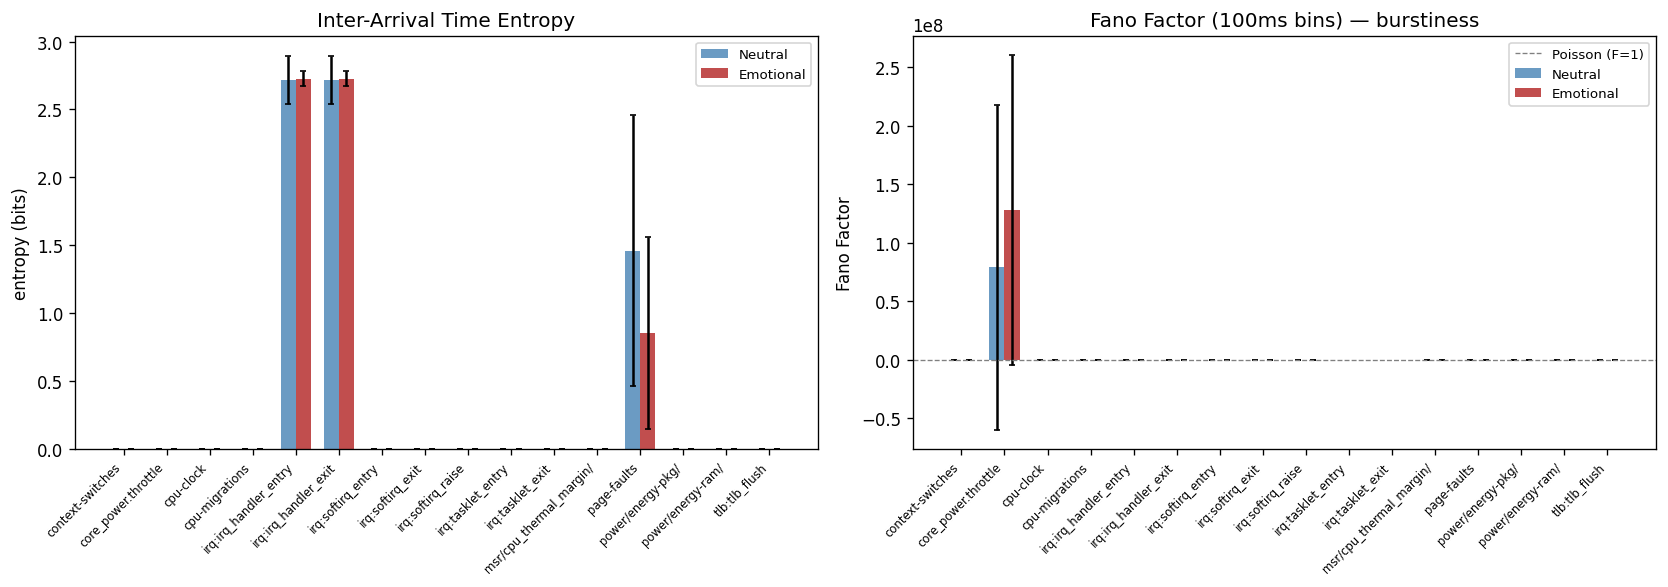

In [18]:
# ── 6.2 plot: Entropy & Fano Factor ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Entropy
x = np.arange(len(common_events))
w = 0.35
ax = axes[0]
ax.bar(x - w/2, temp_df['n_entropy'], w, yerr=temp_df['n_entropy_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_entropy'], w, yerr=temp_df['e_entropy_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('entropy (bits)')
ax.set_title('Inter-Arrival Time Entropy')
ax.legend(fontsize=8)

# Fano Factor
ax = axes[1]
ax.bar(x - w/2, temp_df['n_fano'], w, yerr=temp_df['n_fano_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, temp_df['e_fano'], w, yerr=temp_df['e_fano_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='Poisson (F=1)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('Fano Factor')
ax.set_title('Fano Factor (100ms bins) — burstiness')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 6.3 Burst Statistics
A **burst** = contiguous run of 1ms bins where the event count exceeds
a threshold (mean + 1σ of the per-request series).

- **Burst count**: number of distinct bursts
- **Mean burst size**: average total events within a burst
- **Mean burst duration** (ms): average length of a burst
- **Burst clustering coefficient**: fraction of total events that occur inside bursts.
  Higher → more concentrated activity patterns.

In [ ]:
# ── 6.3  Burst Statistics ──

def burst_stats(series):
    """Detect bursts (contiguous runs > mean+1σ) and return statistics."""
    mu, sigma = series.mean(), series.std()
    if sigma == 0 or mu == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    thresh = mu + sigma
    above = (series > thresh).astype(int)
    # Find burst boundaries via diff
    diff = np.diff(np.concatenate(([0], above, [0])))
    starts = np.where(diff == 1)[0]
    ends   = np.where(diff == -1)[0]
    if len(starts) == 0:
        return dict(burst_count=0, mean_burst_size=0.0,
                    mean_burst_dur_ms=0.0, burst_clustering=0.0)
    burst_sizes = [series[s:e].sum() for s, e in zip(starts, ends)]
    burst_durs  = ends - starts  # in ms
    total_in_bursts = sum(burst_sizes)
    total_events = series.sum()
    return dict(
        burst_count=len(starts),
        mean_burst_size=np.mean(burst_sizes),
        mean_burst_dur_ms=np.mean(burst_durs),
        burst_clustering=total_in_bursts / total_events if total_events > 0 else 0.0,
    )


def compute_burst_features(segments, events):
    rows = []
    for seg in segments:
        dur = seg['_duration_s']
        row = {}
        for evt in events:
            bs = burst_stats(seg[evt])
            for k, v in bs.items():
                row[f'{evt}__{k}'] = v
            # Duration-normalised burst rate (bursts per second)
            row[f'{evt}__burst_rate'] = bs['burst_count'] / dur if dur > 0 else 0.0
        row['_window_duration_s'] = dur
        rows.append(row)
    return pd.DataFrame(rows)

n_burst = compute_burst_features(n_segs, common_events)
e_burst = compute_burst_features(e_segs, common_events)

# ── summary ──
burst_summary = []
for evt in common_events:
    d = {'event': evt}
    for metric in ['burst_count', 'burst_rate', 'mean_burst_size', 'mean_burst_dur_ms', 'burst_clustering']:
        col = f'{evt}__{metric}'
        d[f'n_{metric}'] = n_burst[col].mean()
        d[f'e_{metric}'] = e_burst[col].mean()
    burst_summary.append(d)
burst_df = pd.DataFrame(burst_summary)
print('Burst Statistics (mean across 5 prompts):\n')
print(burst_df.to_string(index=False, float_format='{:.2f}'.format))

Burst Statistics (mean across 5 prompts):

                  event  n_burst_count  e_burst_count  n_mean_burst_size  e_mean_burst_size  n_mean_burst_dur_ms  e_mean_burst_dur_ms  n_burst_clustering  e_burst_clustering
       context-switches          91.20          92.60            6605.34           36344.52                 2.81                14.21                0.28                0.49
    core_power.throttle         117.00         154.40        11782787.46        12755758.15                 1.34                 1.41                0.37                0.39
              cpu-clock          90.60          92.40            1142.00            1275.63                 1.14                 1.15                0.21                0.18
         cpu-migrations          99.20         102.20            2217.73            5460.30                 5.66                13.24                0.26                0.43
  irq:irq_handler_entry          85.00         105.60               8.89               

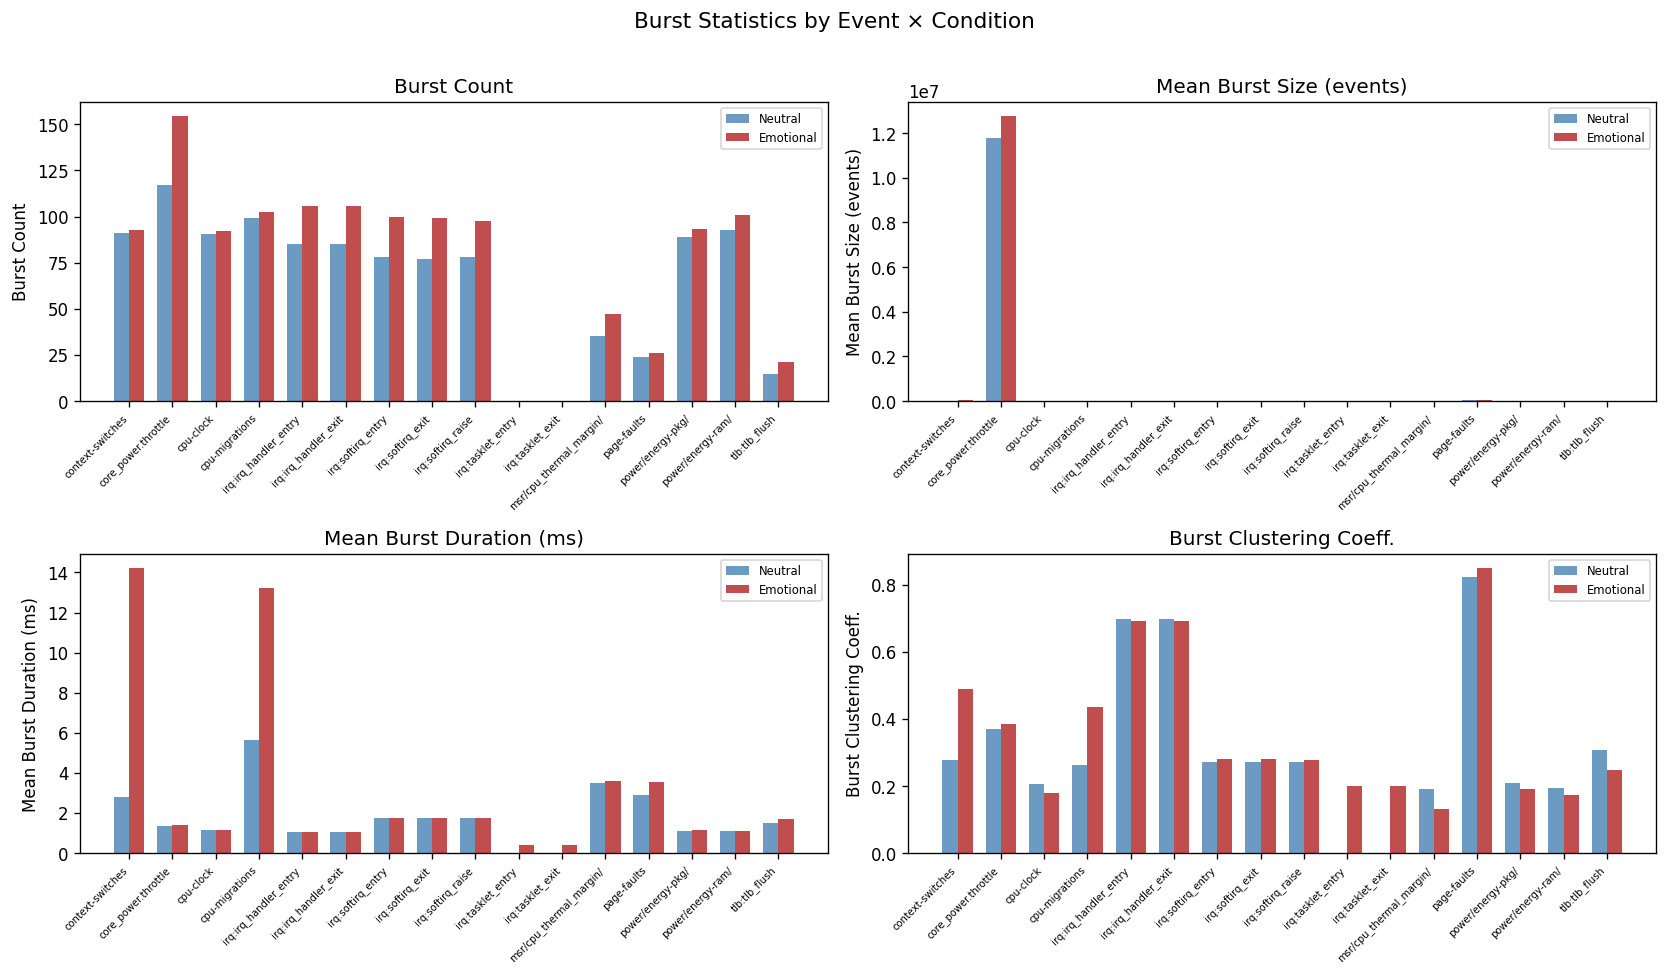

In [20]:
# ── 6.3 plot: Burst Statistics ──
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
x = np.arange(len(common_events))
w = 0.35

metrics = [
    ('burst_count',      'Burst Count',               axes[0, 0]),
    ('mean_burst_size',  'Mean Burst Size (events)',   axes[0, 1]),
    ('mean_burst_dur_ms','Mean Burst Duration (ms)',   axes[1, 0]),
    ('burst_clustering', 'Burst Clustering Coeff.',    axes[1, 1]),
]

for metric, ylabel, ax in metrics:
    n_vals = burst_df[f'n_{metric}'].values
    e_vals = burst_df[f'e_{metric}'].values
    ax.bar(x - w/2, n_vals, w, label='Neutral',   color='steelblue', alpha=0.8)
    ax.bar(x + w/2, e_vals, w, label='Emotional',  color='firebrick', alpha=0.8)
    ax.set_xticks(x)
    ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=6)
    ax.set_ylabel(ylabel)
    ax.set_title(ylabel)
    ax.legend(fontsize=7)

plt.suptitle('Burst Statistics by Event × Condition', fontsize=13, y=1.01)
plt.tight_layout()
plt.show()

## 6.4 Cross-Modal Coupling
Measures *interaction* between different event channels:

- **Max cross-correlation** (lag ±50ms): peak Pearson r between two event time-series.
  We focus on *functionally related* pairs:
  `irq_entry↔softirq_entry`, `softirq_raise↔softirq_entry`,
  `context-switches↔cpu-migrations`, `page-faults↔tlb_flush`,
  `irq_entry↔irq_exit`, `softirq_entry↔softirq_exit`.
- **Mutual Information** (bits): non-linear dependence between the same pairs,
  estimated via histogram binning.

In [21]:
# ── 6.4  Cross-Modal Coupling ──

EVENT_PAIRS = [
    ('irq:irq_handler_entry', 'irq:softirq_entry'),
    ('irq:softirq_raise',     'irq:softirq_entry'),
    ('context-switches',      'cpu-migrations'),
    ('page-faults',            'tlb:tlb_flush'),
    ('irq:irq_handler_entry', 'irq:irq_handler_exit'),
    ('irq:softirq_entry',     'irq:softirq_exit'),
]

# Keep only pairs where both events exist in data
EVENT_PAIRS = [(a, b) for a, b in EVENT_PAIRS
               if a in common_events and b in common_events]
print(f'Event pairs to analyze: {len(EVENT_PAIRS)}')


def max_xcorr(x, y, max_lag=50):
    """Max absolute cross-correlation in ±max_lag ms."""
    x = (x - x.mean()) / (x.std() + 1e-12)
    y = (y - y.mean()) / (y.std() + 1e-12)
    n = len(x)
    best_r, best_lag = 0.0, 0
    for lag in range(-max_lag, max_lag + 1):
        if lag >= 0:
            r = np.dot(x[:n-lag], y[lag:]) / (n - abs(lag))
        else:
            r = np.dot(x[-lag:], y[:n+lag]) / (n - abs(lag))
        if abs(r) > abs(best_r):
            best_r, best_lag = r, lag
    return best_r, best_lag


def mutual_information(x, y, bins=20):
    """MI estimated from 2D histogram (bits)."""
    c_xy = np.histogram2d(x, y, bins=bins)[0]
    c_xy = c_xy / c_xy.sum()
    c_x = c_xy.sum(axis=1)
    c_y = c_xy.sum(axis=0)
    # H(X) + H(Y) - H(X,Y)
    hx  = shannon_entropy_bits(c_x)
    hy  = shannon_entropy_bits(c_y)
    hxy = shannon_entropy_bits(c_xy.ravel())
    return hx + hy - hxy


def compute_coupling_features(segments, pairs):
    rows = []
    for seg in segments:
        row = {}
        for a, b in pairs:
            sa, sb = seg[a], seg[b]
            r, lag = max_xcorr(sa, sb)
            mi = mutual_information(sa, sb)
            pair_label = f'{a}__x__{b}'
            row[f'{pair_label}__xcorr'] = r
            row[f'{pair_label}__xcorr_lag'] = lag
            row[f'{pair_label}__mi'] = mi
        rows.append(row)
    return pd.DataFrame(rows)

n_coup = compute_coupling_features(n_segs, EVENT_PAIRS)
e_coup = compute_coupling_features(e_segs, EVENT_PAIRS)

# ── summary ──
coup_summary = []
for a, b in EVENT_PAIRS:
    pl = f'{a}__x__{b}'
    coup_summary.append({
        'pair': f'{a.split(":")[-1]}↔{b.split(":")[-1]}',
        'n_xcorr': n_coup[f'{pl}__xcorr'].mean(),
        'e_xcorr': e_coup[f'{pl}__xcorr'].mean(),
        'n_lag':   n_coup[f'{pl}__xcorr_lag'].mean(),
        'e_lag':   e_coup[f'{pl}__xcorr_lag'].mean(),
        'n_mi':    n_coup[f'{pl}__mi'].mean(),
        'e_mi':    e_coup[f'{pl}__mi'].mean(),
    })
coup_df = pd.DataFrame(coup_summary)
print('Cross-Modal Coupling (mean over 5 prompts):\n')
print(coup_df.to_string(index=False, float_format='{:.4f}'.format))

Event pairs to analyze: 6
Cross-Modal Coupling (mean over 5 prompts):

                              pair  n_xcorr  e_xcorr  n_lag  e_lag   n_mi   e_mi
   irq_handler_entry↔softirq_entry   0.1014   0.0939 1.2000 7.8000 0.1458 0.1068
       softirq_raise↔softirq_entry   0.9997   0.9997 0.0000 0.0000 2.8459 2.9591
   context-switches↔cpu-migrations   0.9652   0.9946 0.0000 0.0000 1.2484 1.3382
             page-faults↔tlb_flush   0.2165   0.0241 0.8000 2.2000 0.0885 0.0786
irq_handler_entry↔irq_handler_exit   1.0000   1.0000 0.0000 0.0000 1.4069 1.1012
        softirq_entry↔softirq_exit   0.9999   0.9999 0.0000 0.0000 2.9810 3.0922


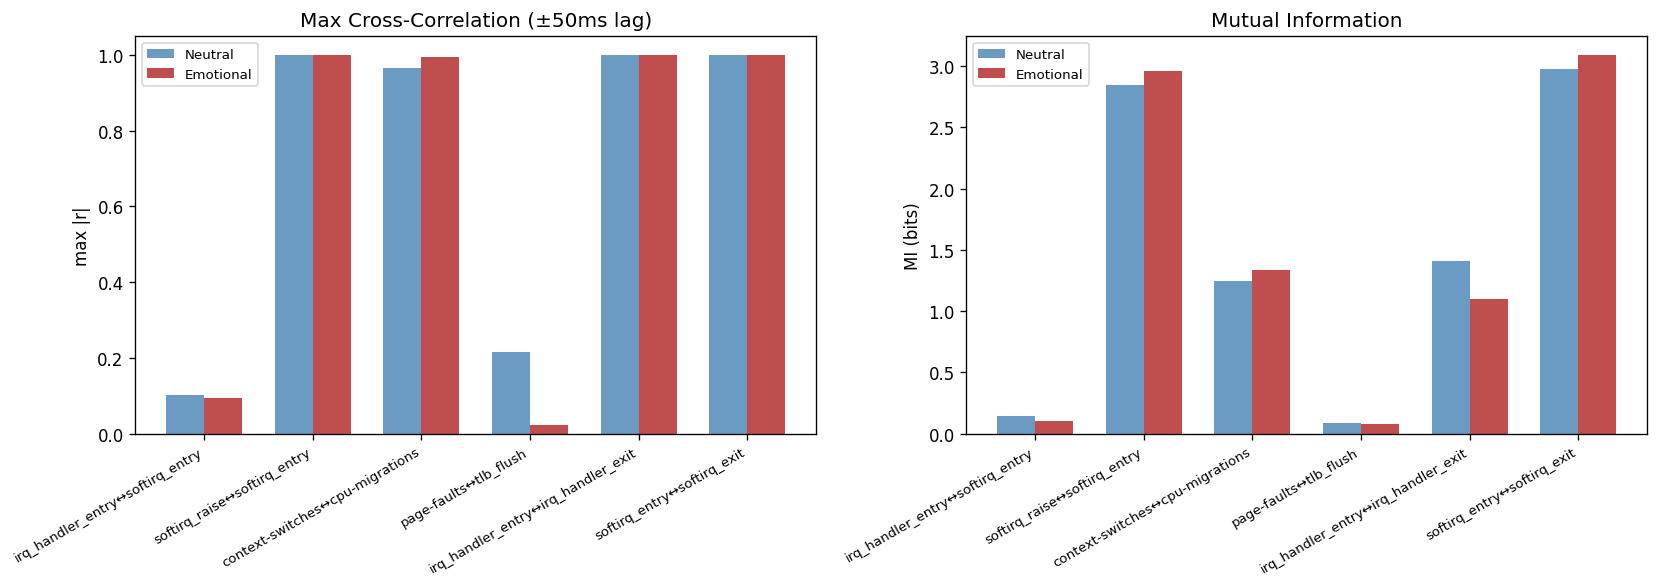

In [22]:
# ── 6.4 plot: Cross-correlation & MI ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(coup_df))
w = 0.35
pair_labels = coup_df['pair'].values

ax = axes[0]
ax.bar(x - w/2, coup_df['n_xcorr'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_xcorr'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('max |r|')
ax.set_title('Max Cross-Correlation (±50ms lag)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, coup_df['n_mi'], w, label='Neutral',  color='steelblue', alpha=0.8)
ax.bar(x + w/2, coup_df['e_mi'], w, label='Emotional', color='firebrick', alpha=0.8)
ax.set_xticks(x)
ax.set_xticklabels(pair_labels, rotation=30, ha='right', fontsize=8)
ax.set_ylabel('MI (bits)')
ax.set_title('Mutual Information')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 6.5 Complexity
- **Lempel-Ziv complexity** (normalised): binarise the 1ms count series
  (above/below median → 1/0), then compute LZ76 complexity normalised by
  $n / \log_2(n)$. Higher → more random/complex; lower → more compressible/patterned.
- **Permutation entropy** (order 3, normalised 0–1): partition the series into
  overlapping ordinal patterns of length 3 and compute the Shannon entropy of
  the pattern distribution ÷ $\log_2(3!)$. 1 → maximally complex; 0 → perfectly periodic.

In [23]:
# ── 6.5  Complexity ──

def lempel_ziv_complexity(binary_seq):
    """LZ76 complexity of a binary string, normalised by n/log2(n)."""
    s = ''.join(str(int(b)) for b in binary_seq)
    n = len(s)
    if n <= 1:
        return 0.0
    i, k, l = 0, 1, 1
    c = 1
    while k + l <= n:
        if s[i + l - 1] == s[k + l - 1]:
            l += 1
        else:
            i += 1
            if i == k:  # new word
                c += 1
                k += l
                i = 0
                l = 1
            else:
                l = 1
    c += 1
    # normalise: theoretical max ≈ n / log2(n)
    return c / (n / np.log2(n)) if n > 1 else 0.0


def permutation_entropy(series, order=3):
    """Normalised permutation entropy (0–1) of order m."""
    n = len(series)
    if n < order:
        return 0.0
    from itertools import permutations as iterperms
    import math
    # Count ordinal patterns
    pattern_counts = defaultdict(int)
    for i in range(n - order + 1):
        window = series[i:i+order]
        # rank pattern
        pattern = tuple(np.argsort(window))
        pattern_counts[pattern] += 1
    total = sum(pattern_counts.values())
    probs = np.array(list(pattern_counts.values())) / total
    h = -np.sum(probs * np.log2(probs + 1e-15))
    h_max = np.log2(math.factorial(order))
    return h / h_max if h_max > 0 else 0.0


def compute_complexity_features(segments, events):
    rows = []
    for seg in segments:
        row = {}
        for evt in events:
            s = seg[evt]
            # Binarise: above median → 1
            binary = (s > np.median(s)).astype(int)
            row[f'{evt}__lz_complexity'] = lempel_ziv_complexity(binary)
            row[f'{evt}__perm_entropy']  = permutation_entropy(s, order=3)
        rows.append(row)
    return pd.DataFrame(rows)

n_complex = compute_complexity_features(n_segs, common_events)
e_complex = compute_complexity_features(e_segs, common_events)

# ── summary ──
complex_summary = []
for evt in common_events:
    lz_col = f'{evt}__lz_complexity'
    pe_col = f'{evt}__perm_entropy'
    complex_summary.append({
        'event': evt,
        'n_lz': n_complex[lz_col].mean(), 'n_lz_std': n_complex[lz_col].std(),
        'e_lz': e_complex[lz_col].mean(), 'e_lz_std': e_complex[lz_col].std(),
        'n_pe': n_complex[pe_col].mean(), 'n_pe_std': n_complex[pe_col].std(),
        'e_pe': e_complex[pe_col].mean(), 'e_pe_std': e_complex[pe_col].std(),
    })
complex_df = pd.DataFrame(complex_summary)
print('Complexity features (mean ± std across 5 prompts):\n')
print(complex_df.to_string(index=False, float_format='{:.4f}'.format))

Complexity features (mean ± std across 5 prompts):

                  event   n_lz  n_lz_std   e_lz  e_lz_std    n_pe  n_pe_std   e_pe  e_pe_std
       context-switches 2.2125    1.9656 1.3343    1.6462  0.9974    0.0027 0.9965    0.0022
    core_power.throttle 3.2628    1.3840 2.5887    1.0505  0.9984    0.0013 0.9979    0.0010
              cpu-clock 3.1885    0.8630 3.3289    0.5439  0.9917    0.0049 0.9888    0.0038
         cpu-migrations 2.1045    1.8580 1.3884    1.7745  0.9905    0.0051 0.9922    0.0068
  irq:irq_handler_entry 4.4064    0.2511 4.5500    0.1290  0.7667    0.0347 0.7603    0.0138
   irq:irq_handler_exit 4.4064    0.2511 4.5500    0.1290  0.7668    0.0347 0.7603    0.0138
      irq:softirq_entry 2.8152    0.7192 2.0687    0.8002  0.9948    0.0040 0.9958    0.0017
       irq:softirq_exit 2.8029    0.7002 2.0781    0.8359  0.9951    0.0039 0.9957    0.0017
      irq:softirq_raise 2.7599    0.7404 2.0713    0.8362  0.9950    0.0039 0.9955    0.0020
      irq:tasklet_

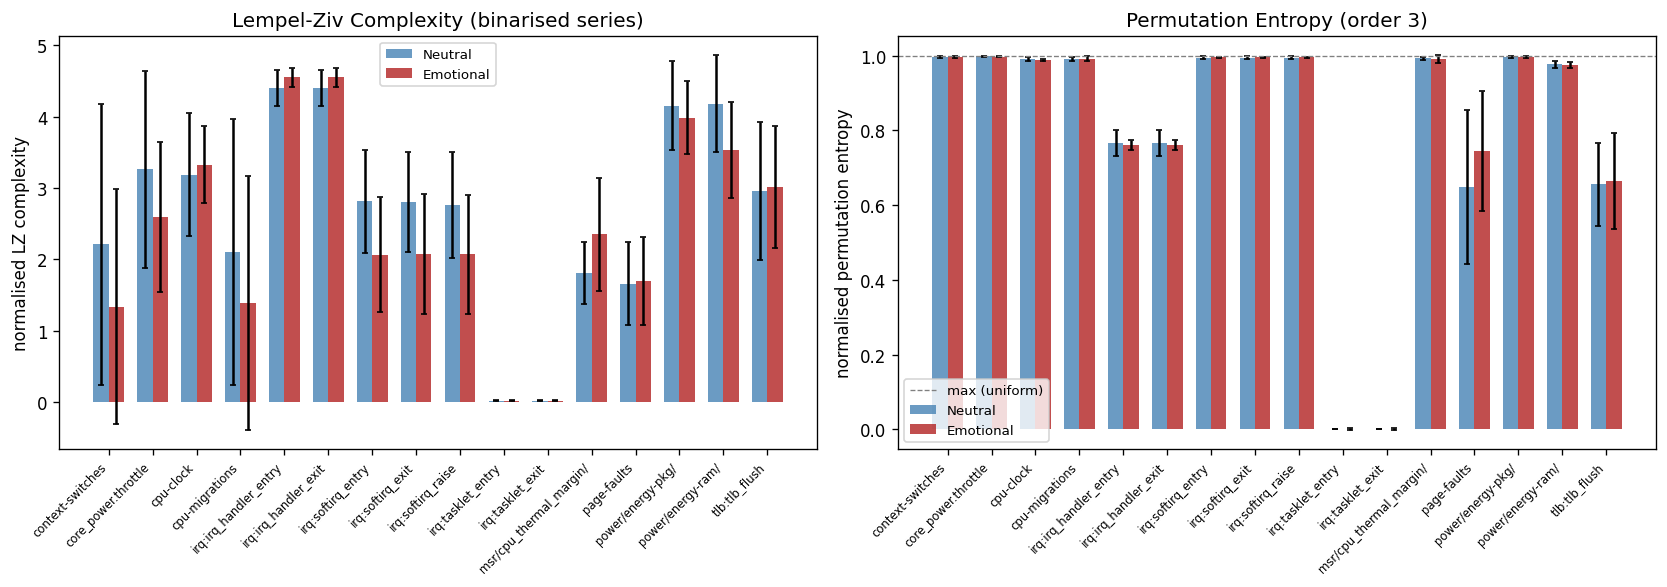

In [24]:
# ── 6.5 plot: Complexity ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
x = np.arange(len(common_events))
w = 0.35

ax = axes[0]
ax.bar(x - w/2, complex_df['n_lz'], w, yerr=complex_df['n_lz_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_lz'], w, yerr=complex_df['e_lz_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised LZ complexity')
ax.set_title('Lempel-Ziv Complexity (binarised series)')
ax.legend(fontsize=8)

ax = axes[1]
ax.bar(x - w/2, complex_df['n_pe'], w, yerr=complex_df['n_pe_std'],
       label='Neutral', color='steelblue', alpha=0.8, capsize=2)
ax.bar(x + w/2, complex_df['e_pe'], w, yerr=complex_df['e_pe_std'],
       label='Emotional', color='firebrick', alpha=0.8, capsize=2)
ax.axhline(1.0, ls='--', color='gray', lw=0.8, label='max (uniform)')
ax.set_xticks(x)
ax.set_xticklabels(common_events, rotation=45, ha='right', fontsize=7)
ax.set_ylabel('normalised permutation entropy')
ax.set_title('Permutation Entropy (order 3)')
ax.legend(fontsize=8)

plt.tight_layout()
plt.show()

## 6.6 Combined Feature Matrix
Merge all features into a single per-prompt row and export to CSV for downstream
statistical tests (Mann-Whitney U, permutation tests, classifiers, etc.).

In [ ]:
# ── 6.6  Combined Feature Matrix ──

def build_feature_matrix(freq, temp, burst, coupling, complexity, condition):
    """Merge all feature DataFrames into one row-per-prompt matrix."""
    combined = pd.concat([freq, temp, burst, coupling, complexity], axis=1)
    combined.insert(0, 'condition', condition)
    combined.insert(1, 'prompt_id', range(len(combined)))
    # Keep window duration for reference (from burst df)
    if '_window_duration_s' in combined.columns:
        combined.insert(2, 'window_duration_s', combined.pop('_window_duration_s'))
    return combined

n_all = build_feature_matrix(n_freq, n_temp, n_burst, n_coup, n_complex, 'neutral')
e_all = build_feature_matrix(e_freq, e_temp, e_burst, e_coup, e_complex, 'emotional')
features = pd.concat([n_all, e_all], ignore_index=True)

print(f'Feature matrix: {features.shape[0]} rows × {features.shape[1]} columns')
print(f'  Neutral rows:   {(features.condition == "neutral").sum()}')
print(f'  Emotional rows: {(features.condition == "emotional").sum()}')
print(f'\nFeature categories:')
print(f'  Frequency:   {sum(c.endswith("__rate") or c.endswith("__share") for c in features.columns)}')
print(f'  Temporal:    {sum(c.endswith("__iat_entropy") or c.endswith("__fano") for c in features.columns)}')
print(f'  Burst:       {sum(any(c.endswith(s) for s in ["__burst_count","__burst_rate","__mean_burst_size","__mean_burst_dur_ms","__burst_clustering"]) for c in features.columns)}')
print(f'  Coupling:    {sum(c.endswith("__xcorr") or c.endswith("__mi") or c.endswith("__xcorr_lag") for c in features.columns)}')
print(f'  Complexity:  {sum(c.endswith("__lz_complexity") or c.endswith("__perm_entropy") for c in features.columns)}')

# ── Save ──
out_path = BASE_DIR / 'features.csv'
features.to_csv(out_path, index=False)
print(f'\nSaved → {out_path}')

Feature matrix: 10 rows × 180 columns
  Neutral rows:   5
  Emotional rows: 5

Feature categories:
  Frequency:   32
  Temporal:    32
  Burst:       64
  Coupling:    18
  Complexity:  32

Saved → /Users/rsalvi/Desktop/mccviahat/runs/features.csv

Saved → /Users/rsalvi/Desktop/mccviahat/runs/features.csv


In [ ]:
# ── 6.6 Quick univariate screening: Mann-Whitney U ──
# (non-parametric, appropriate for n=5 per group)

exclude = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
numeric_cols = [c for c in features.columns if c not in exclude]
n_vals = features[features.condition == 'neutral']
e_vals = features[features.condition == 'emotional']

# Print window durations for reference
print('Window durations (s):')
if 'window_duration_s' in features.columns:
    for cond in ['neutral', 'emotional']:
        durs = features.loc[features.condition == cond, 'window_duration_s']
        print(f'  {cond}: {durs.values}  (mean={durs.mean():.1f})')
print()

results = []
for col in numeric_cols:
    nv = n_vals[col].dropna().values
    ev = e_vals[col].dropna().values
    if len(nv) < 3 or len(ev) < 3:
        continue
    # check for zero-variance
    if nv.std() == 0 and ev.std() == 0:
        continue
    stat, p = sp_stats.mannwhitneyu(nv, ev, alternative='two-sided')
    effect_r = 1 - (2 * stat) / (len(nv) * len(ev))  # rank-biserial r
    results.append({
        'feature': col,
        'U': stat,
        'p': p,
        'effect_r': effect_r,
        'n_mean': nv.mean(),
        'e_mean': ev.mean(),
        'direction': '↑E' if ev.mean() > nv.mean() else '↓E',
    })

mwu_df = pd.DataFrame(results).sort_values('p')
sig = mwu_df[mwu_df.p < 0.10]  # relaxed threshold given n=5
print(f'Features tested: {len(mwu_df)}, significant at p<0.10: {len(sig)}\n')
if len(sig) > 0:
    print(sig[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
        index=False, float_format='{:.4f}'.format))
else:
    print('No features reached p<0.10 (expected with n=5, more runs needed).')
print('\n--- Top 15 features by p-value ---')
print(mwu_df.head(15)[['feature', 'U', 'p', 'effect_r', 'direction']].to_string(
    index=False, float_format='{:.4f}'.format))

Features tested: 159, significant at p<0.10: 4

                                   feature      U      p  effect_r direction
                   power/energy-ram/__fano 3.0000 0.0556    0.7600        ↑E
        context-switches__burst_clustering 3.0000 0.0556    0.7600        ↑E
context-switches__x__cpu-migrations__xcorr 3.0000 0.0556    0.7600        ↑E
        power/energy-ram/__mean_burst_size 4.0000 0.0952    0.6800        ↑E

--- Top 15 features by p-value ---
                                        feature       U      p  effect_r direction
                        power/energy-ram/__fano  3.0000 0.0556    0.7600        ↑E
             context-switches__burst_clustering  3.0000 0.0556    0.7600        ↑E
     context-switches__x__cpu-migrations__xcorr  3.0000 0.0556    0.7600        ↑E
             power/energy-ram/__mean_burst_size  4.0000 0.0952    0.6800        ↑E
               core_power.throttle__burst_count  4.5000 0.1161    0.6400        ↑E
             irq:irq_handler_entr

## 7 · PERMANOVA with Confounders

**PERMANOVA** (Permutation Multivariate Analysis of Variance) tests whether
the *multivariate centroid* of the feature space differs between conditions,
while controlling for confounders via `skbio.stats.distance.permanova`.

**Confounders** — variables that differ between prompts and could mechanically
drive feature differences independent of emotional content:

| Confounder | Why it matters |
|---|---|
| `window_duration_s` | Longer requests → more samples → inflated burst counts, different entropy |
| `tokens_evaluated` | More input tokens → longer prompt-eval phase → different CPU/power profile |
| `tokens_predicted` | If EOS hit early, generation phase is shorter → unequal observation |

**Approach:**
1. Build the full feature matrix (already done in §6.6)
2. Attach confounders from response metadata
3. Residualise features against confounders (OLS regression, keep residuals)
4. Compute Euclidean distance matrix on residuals
5. Run PERMANOVA on condition label (9999 permutations)
6. Also run raw (non-residualised) PERMANOVA for comparison

In [ ]:
# ── 7  PERMANOVA with Confounders ──
from skbio import DistanceMatrix
from skbio.stats.distance import permanova
from scipy.spatial.distance import pdist, squareform

# ── 7a. Attach confounders from response metadata ──
# Build a confounder DataFrame aligned with the feature matrix (5 neutral + 5 emotional)
def get_confounders(resp_df):
    """Extract per-prompt confounders from response data."""
    rows = []
    for _, r in resp_df.iterrows():
        rows.append({
            'tokens_evaluated': r.get('tokens_evaluated', np.nan),
            'tokens_predicted': r.get('tokens_predicted', np.nan),
        })
    return pd.DataFrame(rows)

n_conf = get_confounders(n_resp)
e_conf = get_confounders(e_resp)

# Add window_duration_s if available in features
if 'window_duration_s' in features.columns:
    n_conf['window_duration_s'] = features.loc[features.condition == 'neutral', 'window_duration_s'].values
    e_conf['window_duration_s'] = features.loc[features.condition == 'emotional', 'window_duration_s'].values

confounders = pd.concat([n_conf, e_conf], ignore_index=True)
confounder_cols = [c for c in confounders.columns if confounders[c].notna().sum() >= 5]
print(f'Confounders ({len(confounder_cols)}): {confounder_cols}')
print(confounders.to_string(index=True, float_format='{:.1f}'.format))

# ── 7b. Get numeric features only ──
meta_cols = {'condition', 'prompt_id', 'window_duration_s', '_window_duration_s'}
feat_cols = [c for c in features.columns if c not in meta_cols]
X = features[feat_cols].copy()

# Drop columns that are all-zero or all-NaN
X = X.loc[:, X.std() > 0]
X = X.fillna(0)
print(f'\nFeature matrix for PERMANOVA: {X.shape[0]} samples × {X.shape[1]} features')

In [ ]:
# ── 7c. Residualise features against confounders ──
# For each feature column, regress out the confounders via OLS and keep residuals.
# This removes variance explained by window duration / token counts
# so that PERMANOVA tests condition after controlling for these.

def residualise(X_df, confounders_df, confounder_cols):
    """Regress out confounders from each feature, return residual matrix."""
    C = confounders_df[confounder_cols].fillna(0).values.astype(float)
    # Add intercept
    C = np.column_stack([np.ones(len(C)), C])
    residuals = pd.DataFrame(index=X_df.index, columns=X_df.columns, dtype=float)
    for col in X_df.columns:
        y = X_df[col].values.astype(float)
        # OLS: y = C @ beta + residual
        beta, _, _, _ = np.linalg.lstsq(C, y, rcond=None)
        residuals[col] = y - C @ beta
    return residuals

X_resid = residualise(X, confounders, confounder_cols)
print(f'Residualised feature matrix: {X_resid.shape}')
print(f'Variance explained by confounders (mean R²): ', end='')

# Quick R² check
r2_vals = []
for col in X.columns:
    ss_total = ((X[col] - X[col].mean()) ** 2).sum()
    ss_resid = (X_resid[col] ** 2).sum()
    if ss_total > 0:
        r2_vals.append(1 - ss_resid / ss_total)
print(f'{np.mean(r2_vals):.3f} (range: {np.min(r2_vals):.3f}–{np.max(r2_vals):.3f})')

In [ ]:
# ── 7d. PERMANOVA: raw (no confounder control) ──
# Standardise features before computing distances so all features contribute equally
from sklearn.preprocessing import StandardScaler

X_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X),
    index=X.index, columns=X.columns
)
dm_raw = DistanceMatrix(squareform(pdist(X_scaled, metric='euclidean')))
grouping = features['condition'].values

result_raw = permanova(dm_raw, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RAW features (no confounder control)')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_raw["test statistic"]:.4f}')
print(f'  p-value:                   {result_raw["p-value"]:.4f}')
print(f'  permutations:              {result_raw["number of permutations"]}')
print(f'  sample size:               {result_raw["sample size"]}')
print(f'  number of groups:          {result_raw["number of groups"]}')
print()
if result_raw['p-value'] < 0.05:
    print('  → Significant at α=0.05: conditions differ in multivariate feature space')
elif result_raw['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend toward condition difference')
else:
    print('  → Not significant: no evidence of condition difference (may need more replicates)')

In [ ]:
# ── 7e. PERMANOVA: residualised (confounders removed) ──
X_resid_scaled = pd.DataFrame(
    StandardScaler().fit_transform(X_resid),
    index=X_resid.index, columns=X_resid.columns
)
dm_resid = DistanceMatrix(squareform(pdist(X_resid_scaled, metric='euclidean')))

result_resid = permanova(dm_resid, grouping, permutations=9999)
print('═' * 60)
print('PERMANOVA — RESIDUALISED features (confounders regressed out)')
print(f'  Confounders: {confounder_cols}')
print('═' * 60)
print(f'  test statistic (pseudo-F): {result_resid["test statistic"]:.4f}')
print(f'  p-value:                   {result_resid["p-value"]:.4f}')
print(f'  permutations:              {result_resid["number of permutations"]}')
print(f'  sample size:               {result_resid["sample size"]}')
print(f'  number of groups:          {result_resid["number of groups"]}')
print()
if result_resid['p-value'] < 0.05:
    print('  → Significant at α=0.05: condition effect survives after removing confounder variance')
elif result_resid['p-value'] < 0.10:
    print('  → Marginal at α=0.10: trend persists after confounder control')
else:
    print('  → Not significant after removing confounders')

# ── Compare ──
print('\n' + '─' * 60)
print('COMPARISON')
print('─' * 60)
print(f'  Raw pseudo-F:          {result_raw["test statistic"]:.4f}  (p={result_raw["p-value"]:.4f})')
print(f'  Residualised pseudo-F: {result_resid["test statistic"]:.4f}  (p={result_resid["p-value"]:.4f})')
delta_f = result_resid["test statistic"] - result_raw["test statistic"]
print(f'  Δ pseudo-F:            {delta_f:+.4f}')
if abs(delta_f) < 0.5 * result_raw["test statistic"]:
    print('  → Confounders explain little of the condition effect')
else:
    print('  → Confounders substantially alter the condition effect — interpret with caution')

In [ ]:
# ── 7f. PCoA visualisation: multivariate separation ──
from skbio.stats.ordination import pcoa

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
colors = {'neutral': 'steelblue', 'emotional': 'firebrick'}

for ax, dm, title in [
    (axes[0], dm_raw,   'Raw features'),
    (axes[1], dm_resid, 'Residualised (confounders removed)'),
]:
    pc = pcoa(dm)
    coords = pc.samples[['PC1', 'PC2']].values
    var_explained = pc.proportion_explained[:2].values * 100

    for cond in ['neutral', 'emotional']:
        mask = grouping == cond
        ax.scatter(coords[mask, 0], coords[mask, 1],
                   c=colors[cond], label=cond, s=80, alpha=0.8, edgecolors='white', lw=0.5)

    ax.set_xlabel(f'PC1 ({var_explained[0]:.1f}%)')
    ax.set_ylabel(f'PC2 ({var_explained[1]:.1f}%)')
    ax.set_title(title)
    ax.legend(fontsize=9)
    ax.axhline(0, ls=':', color='gray', lw=0.5)
    ax.axvline(0, ls=':', color='gray', lw=0.5)

plt.suptitle('PCoA — Multivariate Feature Space (Euclidean)', fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

In [ ]:
# ── 7g. PERMDISP — homogeneity of multivariate dispersions ──
# PERMANOVA assumes equal dispersion; if groups have different spread,
# a significant PERMANOVA might reflect dispersion rather than location.
from skbio.stats.distance import permdisp

disp_raw   = permdisp(dm_raw, grouping, permutations=9999)
disp_resid = permdisp(dm_resid, grouping, permutations=9999)

print('═' * 60)
print('PERMDISP — Homogeneity of Multivariate Dispersions')
print('═' * 60)
print(f'\n  Raw features:')
print(f'    test statistic (F): {disp_raw["test statistic"]:.4f}')
print(f'    p-value:            {disp_raw["p-value"]:.4f}')
print(f'\n  Residualised features:')
print(f'    test statistic (F): {disp_resid["test statistic"]:.4f}')
print(f'    p-value:            {disp_resid["p-value"]:.4f}')
print()
for label, result in [('Raw', disp_raw), ('Residualised', disp_resid)]:
    if result['p-value'] < 0.05:
        print(f'  {label}: ⚠ Dispersions differ — PERMANOVA result may reflect spread, not location')
    else:
        print(f'  {label}: ✓ Dispersions are homogeneous — PERMANOVA tests location (centroid) shift')